<a href="https://colab.research.google.com/github/eth212/satellite/blob/master/sat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving quality.zip to quality.zip


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
uploaded = files.upload()

Saving training1.csv to training1.csv


In [0]:
!unzip  "/content/drive/My Drive/quality"
#!unzip quality.zip

Archive:  /content/drive/My Drive/quality.zip
   creating: quality/
  inflating: quality/A0A1A0.png      
  inflating: quality/A0A1B0.png      
 extracting: quality/A0A1C0.png      
  inflating: quality/A0A1E0.png      
  inflating: quality/A0A1G0.png      
  inflating: quality/A0A1H0.png      
  inflating: quality/A0A1J0.png      
  inflating: quality/A0A1K0.png      
  inflating: quality/A0A1L0.png      
  inflating: quality/A0A1M0.png      
  inflating: quality/A0A1N0.png      
 extracting: quality/A0A1P0.png      
  inflating: quality/A0A1R0.png      
  inflating: quality/A0A1S0.png      
  inflating: quality/A0A1V0.png      
 extracting: quality/A0A1W0.png      
  inflating: quality/A0A1X0.png      
  inflating: quality/A0A1Y0.png      
  inflating: quality/A0A1Z0.png      
  inflating: quality/A0A2B0.png      
  inflating: quality/A0A2G0.png      
  inflating: quality/A0A2H0.png      
  inflating: quality/A0A2L0.png      
  inflating: quality/A0A2M0.png      
 extracting: quality

In [2]:
import pandas as pd 
import numpy as np
import os
import cv2
from matplotlib import  pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
buffer = pd.read_csv("training1.csv")
df = pd.DataFrame(buffer)

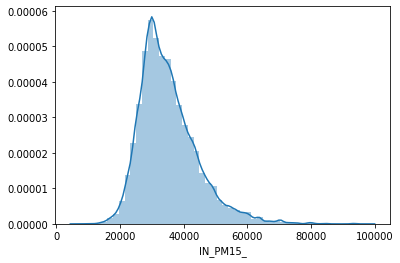

In [4]:
sns.distplot(df["IN_PM15_"])

In [0]:
series = []
low = np.quantile(df["IN_PM15_"], 0.33)
high = np.quantile(df["IN_PM15_"], 0.66)
for i in range(len(df)):
  if df["IN_PM15_"].iloc[i] < low:
    series.append("low") 
  elif high < df["IN_PM15_"].iloc[i]:
    series.append("high")
  else:
    series.append("mid") 
df["Pop"] = series



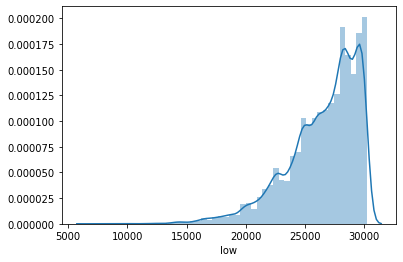

In [8]:
df3 = pd.DataFrame()
df3["low"] = df[df["IN_PM15_"] < low]["IN_PM15_"]
sns.distplot(df3["low"])

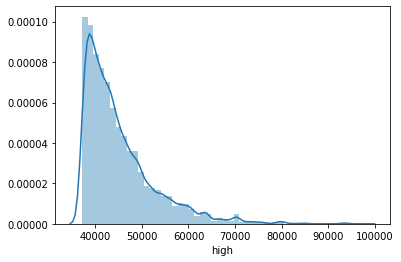

In [9]:
df3 = pd.DataFrame()
df3["high"] = df[df["IN_PM15_"] > high]["IN_PM15_"]
sns.distplot(df3["high"])

In [0]:
df2 = pd.get_dummies(df["Pop"],prefix='income')

In [11]:
df2.head()

income_high  income_low  income_mid
0            0           0           1
1            1           0           0
2            1           0           0
3            0           1           0
4            0           0           1

In [0]:
def augment(image):
  samples = np.expand_dims(image,0)
  datagen = ImageDataGenerator(brightness_range=[1,2], horizontal_flip = True, vertical_flip=True)
  it = datagen.flow(samples, batch_size=1)
  # generate samples and plot
  for j in range(0,10,3):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    data.append(image)
    zooms.append(zoom_val)
    labels.append([df2["income_low"].iloc[i],  df2["income_mid"].iloc[i], df2["income_high"].iloc[i]])


In [0]:
data = []
zooms = []
labels = []
IMG_SZ = 100
white = [255,255,255]

for i in range(0,84000):
        value = str(df["PostCode"].iloc[i])
        path = "quality/" + value + '.png'
        if os.path.exists(path):
            try:
                img=cv2.imread(path)
                zoom_val = df["Zoom"].iloc[i]
                data.append(img)
                zooms.append(zoom_val)
                labels.append([df2["income_low"].iloc[i],  df2["income_mid"].iloc[i], df2["income_high"].iloc[i]])
                augment(img) # creates 9 additional images 

            except Exception as e:
                pass

In [0]:
x_train = np.array(data).reshape(-1,100,100,3) 
x_train = x_train //255 #normalization
zooms = np.array(zooms) 
zooms = zooms // 19 #normalizing using max zoom value
labels = np.array(labels)

In [15]:
len(data)

344580

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Concatenate, Dropout
from keras.layers.merge import concatenate

#create model using zoom values as inputs
model_zoom = Sequential()
model_zoom.add(Dense(20, input_shape=(1,), activation='relu'))


model_img = Sequential()
model_img.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
model_img.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model_img.add(Conv2D(32, kernel_size=3, activation='relu'))
model_img.add(Flatten())
model_img.add(Dense(100,activation='relu'))
model_img.add(Dropout(0.25))
model_img.add(Dense(3, activation='relu'))

conc = Concatenate()([model_zoom.output, model_img.output])
out = Dense(3, activation='softmax')(conc)

model = Model([model_zoom.input, model_img.input], out)

#model = Model(inputs=[model_zoom.input, model_img.input], outputs = model_combined)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#adding precision and recall as metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [18]:
#compile model using accuracy to measure model performance
 model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [0]:
history = model.fit([zooms, x_train],labels, batch_size=500, validation_split = 0.2, shuffle=True, epochs=25)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 275664 samples, validate on 68916 samples
Epoch 1/25





275664/275664 [==============================] - 543s 2ms/step - loss: 1.0660 - acc: 0.4476 - val_loss: 1.2062 - val_acc: 0.2242
Epoch 2/25
275664/275664 [==============================] - 547s 2ms/step - loss: 1.0350 - acc: 0.4779 - val_loss: 1.2208 - val_acc: 0.2313
Epoch 3/25
275664/275664 [==============================] - 548s 2ms/step - loss: 0.9894 - acc: 0.5151 - val_loss: 1.2573 - val_acc: 0.2422
Epoch 4/25
275664/275664 [==============================] - 549s 2ms/step - loss: 0.8870 - acc: 0.5837 - val_loss: 1.2992 - val_acc: 0.2709
Epoch 5/25
275664/275664 [==============================] - 548s 2ms/step - loss: 0.7454 - acc: 0.6602 - val_loss: 1.4109 - val_acc: 0.2798
Epoch 6/25
275664/275664 [==============================] - 549s 2ms/step - loss: 0.6276 - acc: 0.7171 - val_loss: 1.6485 - val_acc: 0.2826
Epoch 7

In [0]:
history.history['val_loss']

[-493162.1940445026, -493162.1940445026, -493162.1940445026]

In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['mae'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
y = model.predict([zooms,x_train]])

In [0]:
distribution(labels)

(170945, 915)

In [0]:
distribution(y)

(171860, 0)

ValueError: ignored

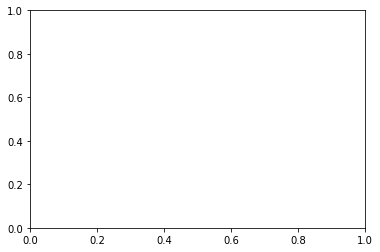

In [0]:
x = np.linspace(0,49999,50000)
plt.scatter(x, y, c="r")
plt.scatter(x,labels[:50000], c="b")
plt.title("blue is the actual, red is predicted")

Text(0.5, 1.0, 'blue is the actual, red is predicted')

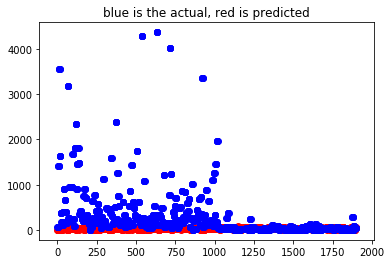

In [0]:
x = np.linspace(0,1899,1900)
plt.scatter(x, y, c="r")
plt.scatter(x,labels[:1900], c="b")
plt.title("blue is the actual, red is predicted")

In [0]:
'''notes:
    try a regression model with Income, Population
    
    classification model determining wheter people bike, drive, 



'''

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Concatenate, MaxPool2D
#create model using zoom values as inputs


model_img = Sequential()
model_img.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,3)))
model_img.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model_img.add(Conv2D(32, kernel_size=3, activation='relu'))
model_img.add(Flatten())
model_img.add(Dense(20,activation='relu'))
model_img.add(Dense(1, activation='relu'))



model_img.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'mae'])
history = model_img.fit(x_train,labels, batch_size=3000, validation_split = 0.2, shuffle=True, epochs=6)

Train on 137528 samples, validate on 34382 samples
Epoch 1/10


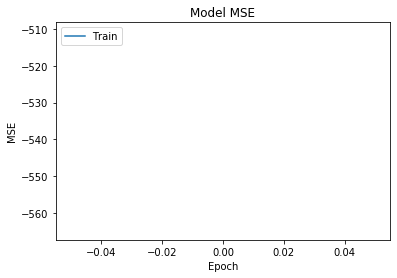

In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['mae'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
def distribution(arr):
  alt = list(zip(*arr))
  fir = 0
  sec = 0
  thi = 0
  for i in range(len(alt[0])):
    if round(alt[0][i]) == 1:
      fir += 1
    if round(alt[1][i]) == 1:
      sec += 1
    if round(alt[2][i]) == 1:
      thi += 1
  return fir, sec, thi